<a href="https://colab.research.google.com/github/sam4410/AI-Engineering-Projects/blob/main/Fine_Tuning_LLAMA_3_1_8B_Model_for_Product_Price_Prediction_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip installs
!pip install -q datasets==2.21.0 requests torch peft bitsandbytes==0.45.0 transformers trl accelerate sentencepiece wandb matplotlib

In [ ]:
# imports
import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, set_seed, BitsAndBytesConfig
from datasets import load_dataset, Dataset, DatasetDict
import wandb
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Constants
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
PROJECT_NAME = "pricer_appliance_category"
HF_USER = "sam4410"

# Data
DATASET_NAME = f"{HF_USER}/appliances_data_only"
MAX_SEQUENCE_LENGTH = 182

# Run name for saving the model in the hub
RUN_NAME =  f"{datetime.now():%Y-%m-%d_%H.%M.%S}"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
HUB_MODEL_NAME = f"{HF_USER}/{PROJECT_RUN_NAME}"

# Hyperparameters for QLoRA
LORA_R = 8
LORA_ALPHA = 16
TARGET_MODULES = ["q_proj", "v_proj", "k_proj", "o_proj"]
LORA_DROPOUT = 0.1
QUANT_4_BIT = True

# Hyperparameters for Training
EPOCHS = 1
BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = 1
LEARNING_RATE = 1e-4
LR_SCHEDULER_TYPE = 'cosine'
WARMUP_RATIO = 0.03
OPTIMIZER = "paged_adamw_32bit"

# Admin config
STEPS = 50
SAVE_STEPS = 500
LOG_TO_WANDB = True

In [ ]:
# Log in to HuggingFace
hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [ ]:
# Log in to Weights & Biases
wandb_api_key = userdata.get('WANDB_API_KEY')
os.environ["WANDB_API_KEY"] = wandb_api_key
wandb.login()

# Configure Weights & Biases to record against our project
os.environ["WANDB_PROJECT"] = PROJECT_NAME
os.environ["WANDB_LOG_MODEL"] = "checkpoint" if LOG_TO_WANDB else "end"
os.environ["WANDB_WATCH"] = "gradients"

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sharma-manoj84 (sharma-manoj84-1rivet). Use `wandb login --relogin` to force relogin


## 1. Loading Data from Hugging Face

In [ ]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

In [ ]:
print(len(train))
print(len(test))
print(train[0])
print(test[0])

25000
2000
{'text': 'How much does this cost to the nearest dollar?\n\nand Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)\nContents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil\n\nPrice is $12.00', 'price': 11.99}
{'text': "How much does this cost to the nearest dollar?\n\nSetpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only\nInsulation & Waterproof well-made insulation could save battery power and improve cooli

In [ ]:
if LOG_TO_WANDB:
  wandb.init(project=PROJECT_NAME, name=RUN_NAME)

In [ ]:
# pick the right quantization
if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

## 2. Loading Pre-trained Llama 3.1 8b Model & Tokenizer from Hugging Face

In [ ]:
# Load the Tokenizer and the Model
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e6:.1f} MB")

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Memory footprint: 5591.5 MB


#### Data Collator

It's important that we ensure during Training that we are not trying to train the model to predict the description of products; only their price. We need to tell the trainer that everything up to "Price is $" is there to give context to the model to predict the next token, but does not need to be learned.

The trainer needs to teach the model to predict the token(s) after "Price is $". There is a complicated way to do this by setting Masks, but luckily HuggingFace provides a super simple helper class to take care of this for us.

In [ ]:
from trl import DataCollatorForCompletionOnlyLM
response_template = "Price is $"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

## 3. Training

#### Set up the configuration for Training

We need to create 2 objects:

A LoraConfig object with our hyperparameters for LoRA

An SFTConfig with our overall Training parameters

In [ ]:
# First, specify the configuration parameters for LoRA
lora_parameters = LoraConfig(
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    r=LORA_R,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=TARGET_MODULES,
)

# Next, specify the general configuration parameters for training
train_parameters = SFTConfig(
    output_dir=PROJECT_RUN_NAME,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=1,
    eval_strategy="no",
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    optim=OPTIMIZER,
    save_steps=SAVE_STEPS,
    save_total_limit=10,
    logging_steps=STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.001,
    fp16=False,
    bf16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=WARMUP_RATIO,
    group_by_length=True,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    report_to="wandb" if LOG_TO_WANDB else None,
    run_name=RUN_NAME,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    dataset_text_field="text",
    save_strategy="steps",
    hub_strategy="every_save",
    push_to_hub=True,
    hub_model_id=HUB_MODEL_NAME,
    hub_private_repo=True
)

# And now, the Supervised Fine Tuning Trainer will carry out the fine-tuning. Given these 2 sets of configuration parameters
fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=train,
    peft_config=lora_parameters,
    tokenizer=tokenizer,
    args=train_parameters,
    data_collator=collator
)

<ipython-input-12-7fe2dc297d27>:44: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  fine_tuning = SFTTrainer(


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
# Fine-tune!
fine_tuning.train()

# Push our fine-tuned model to Hugging Face
fine_tuning.model.push_to_hub(PROJECT_RUN_NAME, private=True)
print(f"Saved to the hub: {PROJECT_RUN_NAME}")

Step,Training Loss
50,2.131000
100,1.396200
150,1.398800
200,1.412100
250,1.417500
300,1.400700
350,1.369400
400,1.313900
450,1.378500
500,1.409600


wandb: Adding directory to artifact (./pricer_appliance_category-2024-12-21_11.54.42/checkpoint-500)... Done. 0.3s
wandb: Adding directory to artifact (./pricer_appliance_category-2024-12-21_11.54.42/checkpoint-1000)... Done. 0.4s


In [ ]:
if LOG_TO_WANDB:
  wandb.finish()

### Model Evaluation on Test Dataset

In [ ]:
import torch.nn.functional as F
from peft import PeftModel

In [ ]:
# Constants
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
PROJECT_NAME = "pricer_appliance_category"
HF_USER = "sam4410"

# The run itself
RUN_NAME = "2024-12-21_11.54.42"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
REVISION = "62075af0f253ccc4d3d70cec0d592758ccc7a416" # or REVISION = None
FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"

# Data
DATASET_NAME = f"{HF_USER}/appliances_data_only"

# Hyperparameters for QLoRA
QUANT_4_BIT = True

# Used for writing to output in color
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [ ]:
# # Log in to HuggingFace
# hf_token = userdata.get('HF_TOKEN')
# login(hf_token, add_to_git_credential=True)

# # Get data
# dataset = load_dataset(DATASET_NAME)
# train = dataset['train']
# test = dataset['test']

In [ ]:
# # pick the right quantization
# if QUANT_4_BIT:
#   quant_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_compute_dtype=torch.bfloat16,
#     bnb_4bit_quant_type="nf4"
#   )
# else:
#   bnb_config = BitsAndBytesConfig(
#     load_in_8bit=True,
#     bnb_8bit_compute_dtype=torch.bfloat16
#   )

In [ ]:
# Load the Tokenizer and the Model
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

# Load the fine-tuned model with PEFT
if REVISION:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL, revision=REVISION)
else:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)


print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/751 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/27.3M [00:00<?, ?B/s]

Memory footprint: 5618.8 MB


In [ ]:
# fine_tuned_model

In [ ]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [ ]:
#extract_price("Price is $a fabulous 899.99 or so")

In [ ]:
# # Original prediction function takes the most likely next token
# def model_predict(prompt):
#     set_seed(42)
#     inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
#     attention_mask = torch.ones(inputs.shape, device="cuda")
#     outputs = fine_tuned_model.generate(inputs, attention_mask=attention_mask, max_new_tokens=3, num_return_sequences=1)
#     response = tokenizer.decode(outputs[0])
#     return extract_price(response)

In [ ]:
# An improved prediction function takes a weighted average of the top 3 choices. This code would be more complex if we couldn't take advantage of the fact
# That Llama generates 1 token for any 3 digit number
top_K = 3

def improved_model_predict(prompt, device="cuda"):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad():
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)
    prices, weights = [], []
    for i in range(top_K):
      predicted_token = tokenizer.decode(top_token_id[0][i])
      probability = top_prob[0][i]
      try:
        result = float(predicted_token)
      except ValueError as e:
        result = 0.0
      if result > 0:
        prices.append(result)
        weights.append(probability)
    if not prices:
      return 0.0, 0.0
    total = sum(weights)
    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
    return sum(weighted_prices).item()

In [ ]:
class Tester:
    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $21.78 Truth: $65.99 Error: $44.21 SLE: 1.16 Item: Setpower Insulated P...
2: Guess: $8.34 Truth: $9.68 Error: $1.34 SLE: 0.02 Item: TUAIC Refrigerator D...
3: Guess: $50.38 Truth: $155.98 Error: $105.60 SLE: 1.25 Item: Kegco Secondary Regu...
4: Guess: $10.27 Truth: $5.59 Error: $4.68 SLE: 0.29 Item: Refrigerator Door Sp...
5: Guess: $15.74 Truth: $98.40 Error: $82.66 SLE: 3.17 Item: Ice-O-Matic Float Va...
6: Guess: $25.22 Truth: $54.99 Error: $29.77 SLE: 0.58 Item: Wireless Temperature...
7: Guess: $9.09 Truth: $5.71 Error: $3.38 SLE: 0.17 Item: 3Inch Thermometer Hy...
8: Guess: $9.08 Truth: $9.53 Error: $0.45 SLE: 0.00 Item: GE GE Timer Knob Ass...
9: Guess: $10.23 Truth: $11.24 Error: $1.01 SLE: 0.01 Item: newlifeapp Dryer Lin...
10: Guess: $22.17 Truth: $12.88 Error: $9.29 SLE: 0.26 Item: Away NV350 NV351 NV3...
11: Guess: $76.50 Truth: $99.99 Error: $23.49 SLE: 0.07 Item: Refrigerator Ice Mak...
12: Guess: $10.95 Truth: $16.99 Error: $6.04 SLE: 0.17 Item: 2 PACKS Water

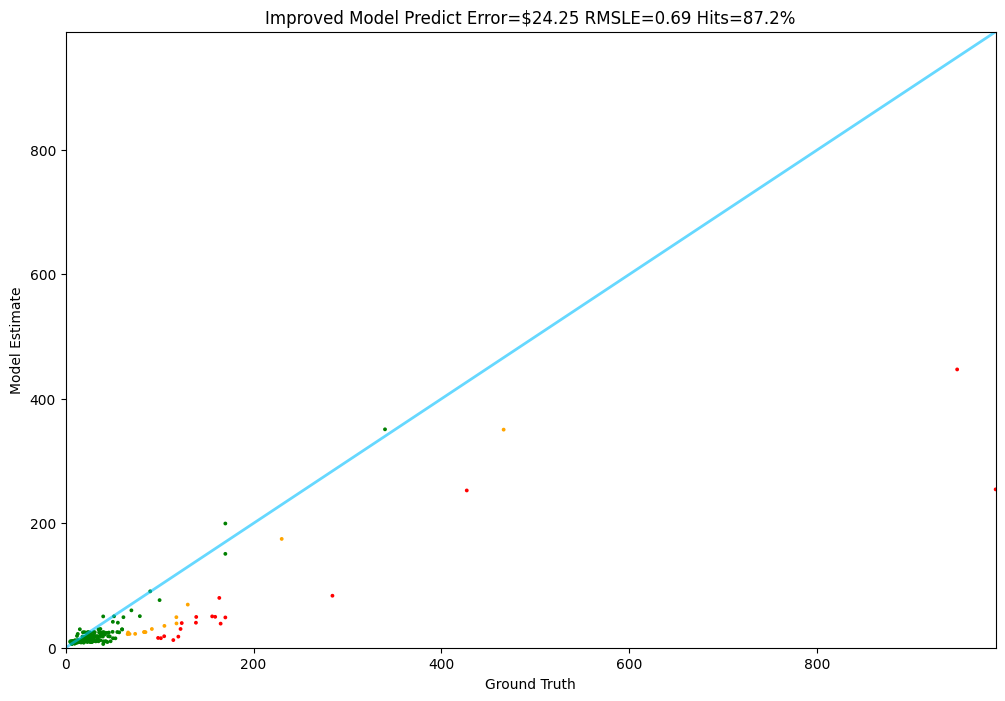

In [ ]:
Tester.test(improved_model_predict, test)